# Genetic alorithm

In [39]:
# Imports
import pickle

from deap import base
from deap import creator
from deap import tools

import numpy as np
from qiskit.primitives import Estimator

import sys
sys.path.append('../../')
import src.customFunc as cf
import src.ansatzs as anz


import matplotlib.pyplot as plt


# ====================================================================
#            VQE implementation for BP study
# ====================================================================
def VQE_minimization_AG(ansatz_function, minQubits: int, maxQubits: int, base_observable, stop_condition : float, population_size : int = 100, max_iters : int = 100, print_info: bool = True, plot_info: bool = True):
    """
    Compute the VQE algorithm using different numbers of qubits, then plot the minimization progess and the derivatives information.
    -----------------------------------------
    Args:
        ansatz_function (method): A function defined as follows: ansatz_function(N_qubits (int)) -> qc (QuantumCircuit), num_params (int)
        minQubits (int): The smallest number of qubits used.
        maxQubits (int): The greatest number of qubits used.
        base_observable (SparsePauliOp): The observable to be measured in its minimal form, it should use minQubits number of qubits.
        index (list[int] or str): With respect to which parameters the derivative will be taken. If given "all", it calculates all the derivatives.
        initial_guess (str or NumPy 1D array): "zero" initial guess with all parameters equal to cero, "rand" -> random initial guess. 1D Array -> the initial guess. default="zero".
        minimizer (str): scipy.optimize.minimize possible optimization methods, default="COBYLA".
    -----------------------------------------
    Returns:
        (Dictionary): 
            "minimum_values" : (list[float]): A list containing the minimum found for every number of qubits.
            "n_qubits" : (list[int]): A list containing the number of qubits used.
    """

    data = {
        "n_qubits": [],
        "minimum_values": [],
        "optimal_parameters": [],
        "n_evaluations" : [],
        "n_generations" : []
    }

    for i in range(minQubits, maxQubits+1):

        estimator = Estimator()
        
        current_observable = cf.expand_observable(base_observable, i)
        ansatz_circuit, num_params = ansatz_function(i)

        # Current iteration information
        if print_info:
            print("\n=====================================================")
            print(f"Preparando ejecución para {i} qubits.")
            print(f"Se usarán {num_params} parámetros")
        
        # Dictionary to save the evolution of the cost function
        cost_history_dict = {
            "cost_history": []
        }

        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()
        # Attribute generator 
        toolbox.register("attr_phase", np.random.uniform, 0, 2*np.pi)
        # Structure initializers
        toolbox.register("individual", tools.initRepeat, creator.Individual, 
            toolbox.attr_phase, num_params)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)


        def evalOneMax(individual):
            return [-cf.evaluate_observable(np.array(individual), ansatz_circuit, current_observable, estimator)]
        

        toolbox.register("evaluate", evalOneMax)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selTournament, tournsize=3)

        def perform_AG():
            # Create population
            pop = toolbox.population(n=population_size)

            # Evaluate the entire population
            fitnesses = list(map(toolbox.evaluate, pop))
            for ind, fit in zip(pop, fitnesses):
                ind.fitness.values = fit
            
            # CXPB  is the probability with which two individuals
            #       are crossed
            #
            # MUTPB is the probability for mutating an individual
            CXPB, MUTPB = 0.5, 0.2

            # Extracting all the fitnesses of 
            fits = [ind.fitness.values[0] for ind in pop]
            n_evaluations = population_size

            # Variable keeping track of the number of generations
            g = 0

            # Begin the evolution
            while max(fits) < -stop_condition and g < max_iters:
                # A new generation
                g = g + 1
            
                # Select the next generation individuals
                offspring = toolbox.select(pop, len(pop))
                # Clone the selected individuals
                offspring = list(map(toolbox.clone, offspring))
            
                # Apply crossover and mutation on the offspring
                for child1, child2 in zip(offspring[::2], offspring[1::2]):
                    if np.random.random() < CXPB:
                        toolbox.mate(child1, child2)
                        del child1.fitness.values
                        del child2.fitness.values

                for mutant in offspring:
                    if np.random.random() < MUTPB:
                        toolbox.mutate(mutant)
                        del mutant.fitness.values


                # Evaluate the individuals with an invalid fitness
                invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
                fitnesses = map(toolbox.evaluate, invalid_ind)
                for ind, fit in zip(invalid_ind, fitnesses):
                    ind.fitness.values = fit
                    n_evaluations += 1
                
                pop[:] = offspring

                # Gather all the fitnesses in one list and print the stats
                fits = [ind.fitness.values[0] for ind in pop]

                cost_history_dict["cost_history"].append(-max(fits))

            best_fit = max(fits)
            best_params = pop[fits.index(max(fits))]

            return -best_fit, best_params, g, n_evaluations
        
        opt_value, opt_parametes, n_generations, n_evaluations= perform_AG()


        # Save the results in the dictionary
        data["n_qubits"].append(i)
        data["minimum_values"].append(opt_value)
        data["optimal_parameters"].append(opt_parametes)
        data["n_evaluations"].append(n_evaluations)
        data["n_generations"].append(n_generations)

        # Show the evolution of the cost function
        if plot_info:
            fig, ax = plt.subplots()
            ax.plot(range(1, n_generations+1), cost_history_dict["cost_history"], label=r"$\langle O\rangle$")

            ax.set_xlabel("Generaciones")
            ax.set_ylabel(r"$\langle O\rangle$")
            ax.set_title(f"Minimización para {i} qubits")
            plt.legend()
            plt.show()

        if print_info:
            print(f"Fin ejecución con {i} qubits. Mínimo encontrado: {opt_value}")
            print(f"Número de generaciones: {n_generations}")
            print(f"Número de evaluaciones de la función de coste: {n_evaluations}")
            print("=====================================================")

    return data

## H2 Molecule

In [33]:
# Hamiltonians
with open(f"H2/data/hamiltonian0.719.pkl", "rb") as f:
    hamiltonian_H2 = pickle.load(f)

### N-local ansatz


Preparando ejecución para 4 qubits.
Se usarán 18 parámetros


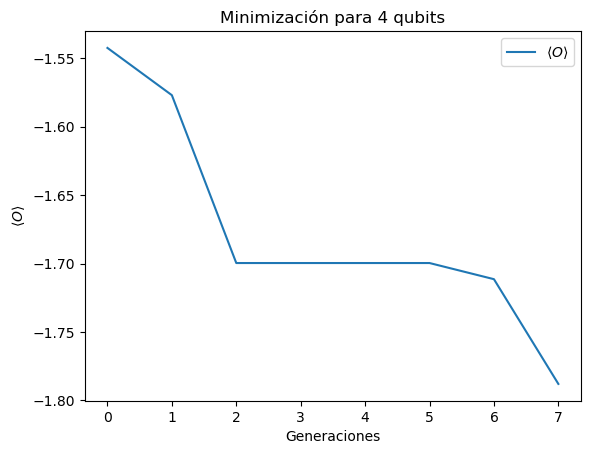

Fin ejecución con 4 qubits. Mínimo encontrado: -1.7879214713843181
Número de generaciones: 8
Número de evaluaciones de la función de coste: 2887

Preparando ejecución para 5 qubits.
Se usarán 21 parámetros


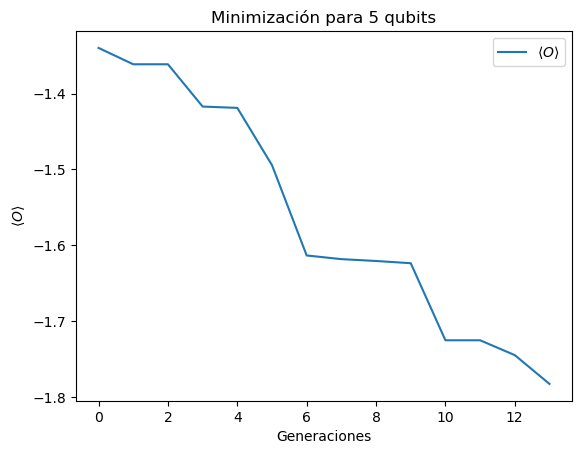

Fin ejecución con 5 qubits. Mínimo encontrado: -1.7826930753341188
Número de generaciones: 14
Número de evaluaciones de la función de coste: 4681

Preparando ejecución para 6 qubits.
Se usarán 27 parámetros


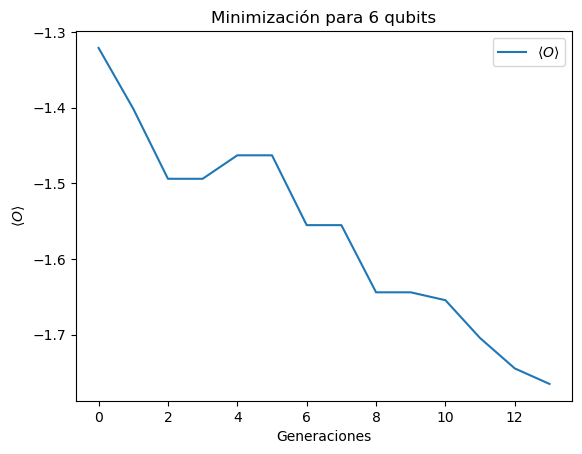

Fin ejecución con 6 qubits. Mínimo encontrado: -1.7653051752586104
Número de generaciones: 14
Número de evaluaciones de la función de coste: 4668

Preparando ejecución para 7 qubits.
Se usarán 30 parámetros


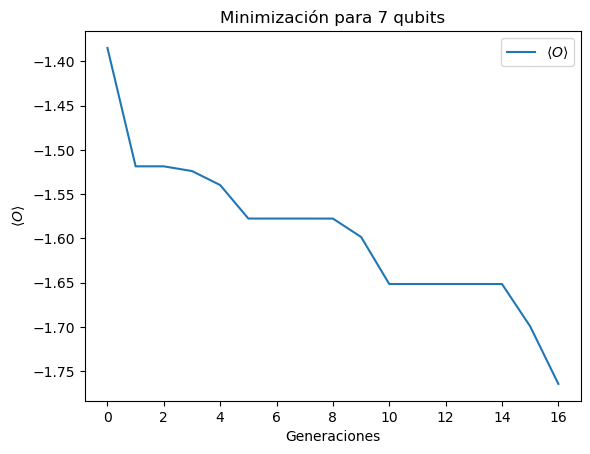

Fin ejecución con 7 qubits. Mínimo encontrado: -1.76446444882611
Número de generaciones: 17
Número de evaluaciones de la función de coste: 5608

Preparando ejecución para 8 qubits.
Se usarán 36 parámetros


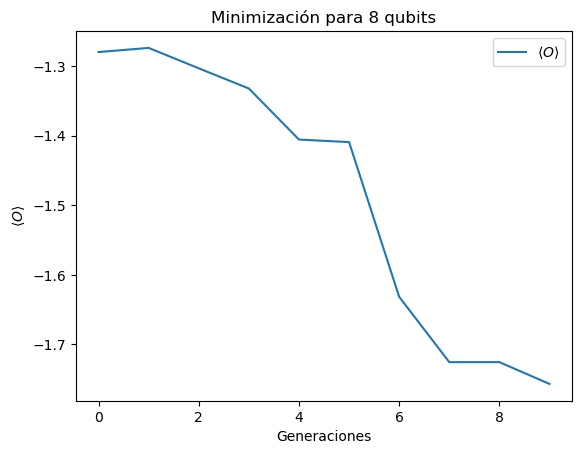

Fin ejecución con 8 qubits. Mínimo encontrado: -1.7566986535446336
Número de generaciones: 10
Número de evaluaciones de la función de coste: 3502

Preparando ejecución para 9 qubits.
Se usarán 39 parámetros


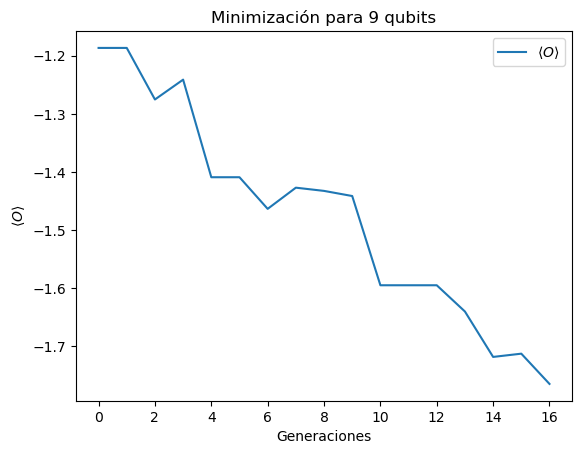

Fin ejecución con 9 qubits. Mínimo encontrado: -1.764567070463534
Número de generaciones: 17
Número de evaluaciones de la función de coste: 5529

Preparando ejecución para 10 qubits.
Se usarán 45 parámetros


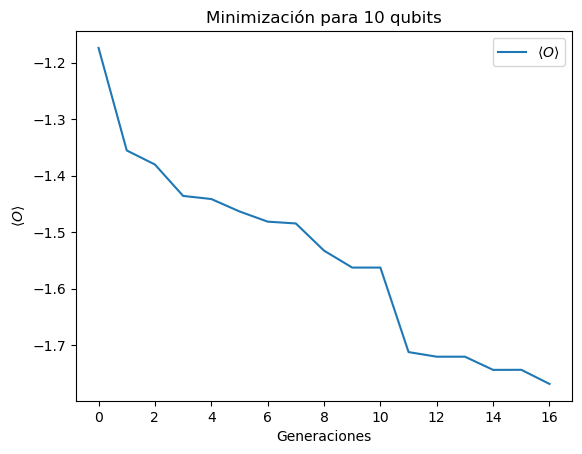

Fin ejecución con 10 qubits. Mínimo encontrado: -1.7686184293056844
Número de generaciones: 17
Número de evaluaciones de la función de coste: 5601

Preparando ejecución para 11 qubits.
Se usarán 48 parámetros


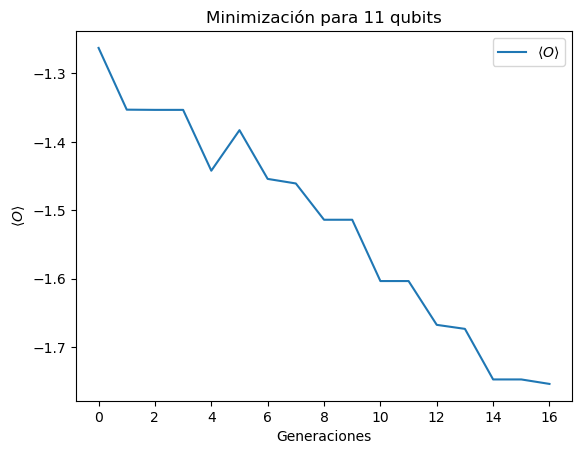

Fin ejecución con 11 qubits. Mínimo encontrado: -1.7538513462843948
Número de generaciones: 17
Número de evaluaciones de la función de coste: 5540

Preparando ejecución para 12 qubits.
Se usarán 54 parámetros


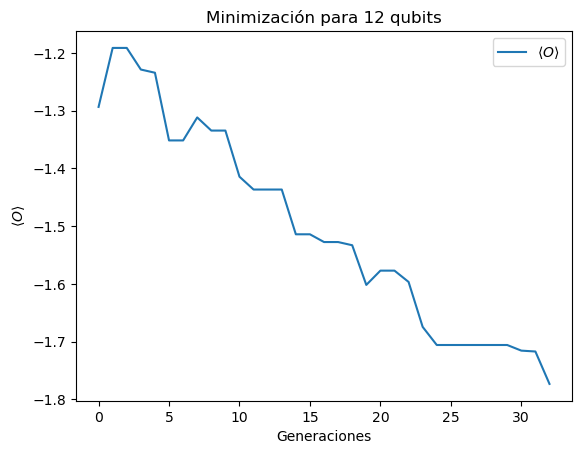

Fin ejecución con 12 qubits. Mínimo encontrado: -1.7732881873349366
Número de generaciones: 33
Número de evaluaciones de la función de coste: 10529


In [ ]:
data = VQE_minimization_AG(anz.build_Nlocal_ansatz, 4, 12, hamiltonian_H2, -1.75, population_size=500, max_iters=1000)

### 2-local ansatz


Preparando ejecución para 4 qubits.
Se usarán 8 parámetros


c:\Users\juanl\miniconda3\envs\qiskit-tfm\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\juanl\miniconda3\envs\qiskit-tfm\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


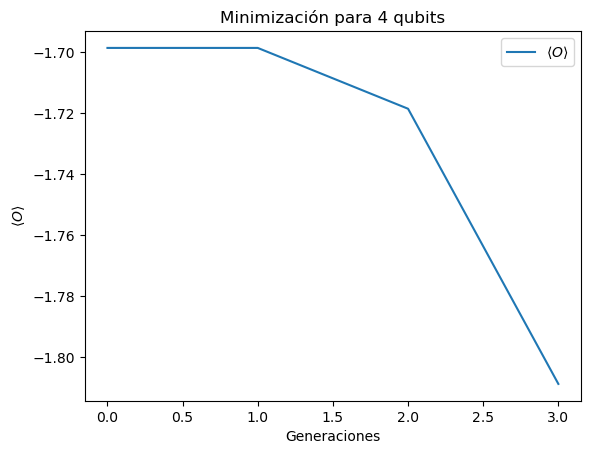

Fin ejecución con 4 qubits. Mínimo encontrado: -1.8088632424583468
Número de generaciones: 4
Número de evaluaciones de la función de coste: 1719

Preparando ejecución para 5 qubits.
Se usarán 10 parámetros


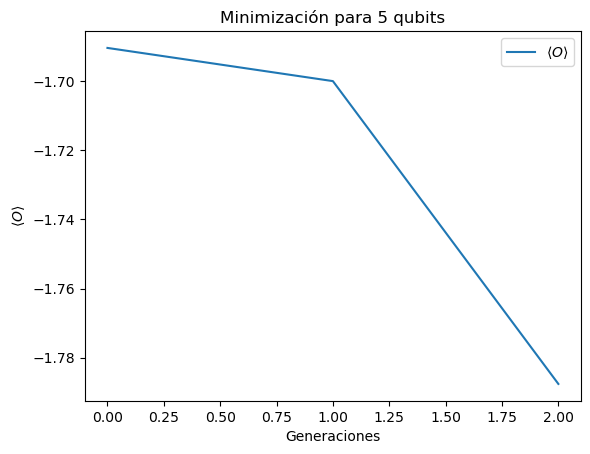

Fin ejecución con 5 qubits. Mínimo encontrado: -1.787578266342354
Número de generaciones: 3
Número de evaluaciones de la función de coste: 1437

Preparando ejecución para 6 qubits.
Se usarán 12 parámetros


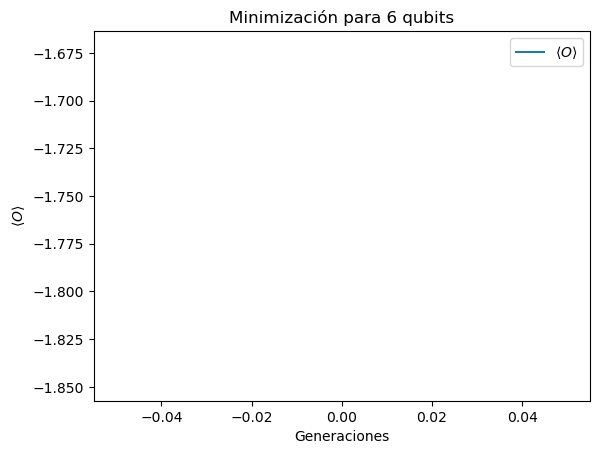

Fin ejecución con 6 qubits. Mínimo encontrado: -1.7604074671217826
Número de generaciones: 1
Número de evaluaciones de la función de coste: 790

Preparando ejecución para 7 qubits.
Se usarán 14 parámetros


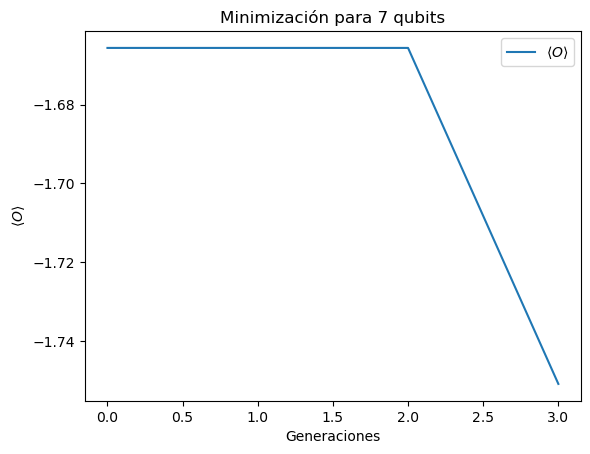

Fin ejecución con 7 qubits. Mínimo encontrado: -1.7509153544196565
Número de generaciones: 4
Número de evaluaciones de la función de coste: 1708

Preparando ejecución para 8 qubits.
Se usarán 16 parámetros


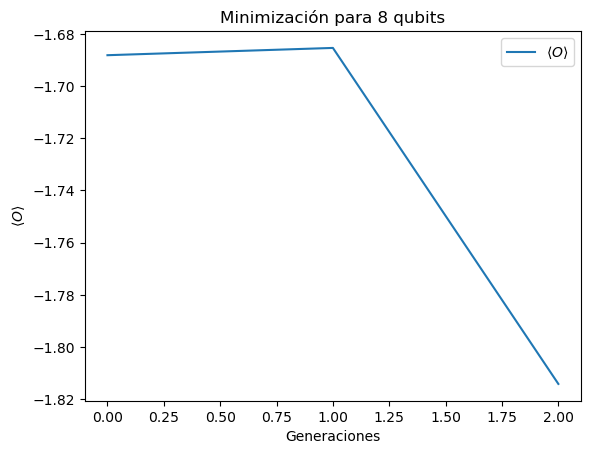

Fin ejecución con 8 qubits. Mínimo encontrado: -1.814169256410014
Número de generaciones: 3
Número de evaluaciones de la función de coste: 1466

Preparando ejecución para 9 qubits.
Se usarán 18 parámetros


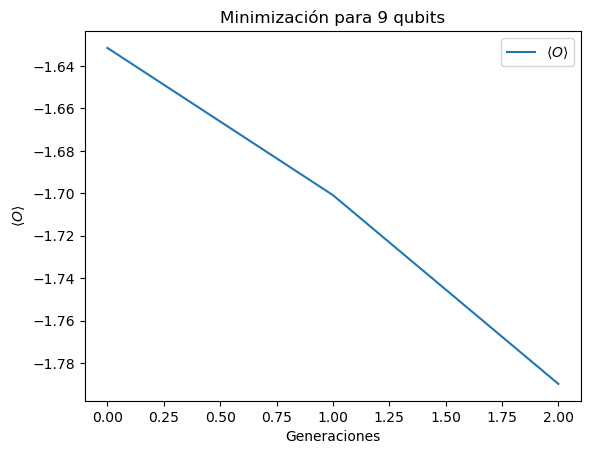

Fin ejecución con 9 qubits. Mínimo encontrado: -1.789826100932832
Número de generaciones: 3
Número de evaluaciones de la función de coste: 1408

Preparando ejecución para 10 qubits.
Se usarán 20 parámetros


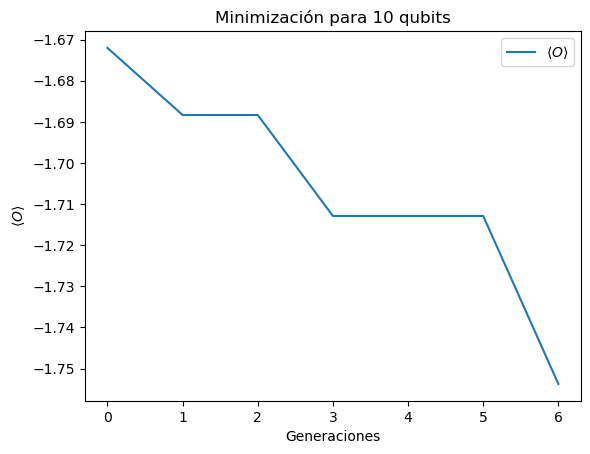

Fin ejecución con 10 qubits. Mínimo encontrado: -1.7537245796833902
Número de generaciones: 7
Número de evaluaciones de la función de coste: 2616

Preparando ejecución para 11 qubits.
Se usarán 22 parámetros


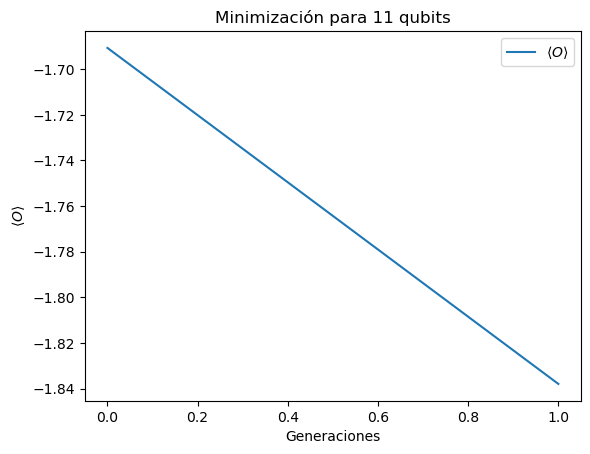

Fin ejecución con 11 qubits. Mínimo encontrado: -1.8379895086192608
Número de generaciones: 2
Número de evaluaciones de la función de coste: 1121

Preparando ejecución para 12 qubits.
Se usarán 24 parámetros


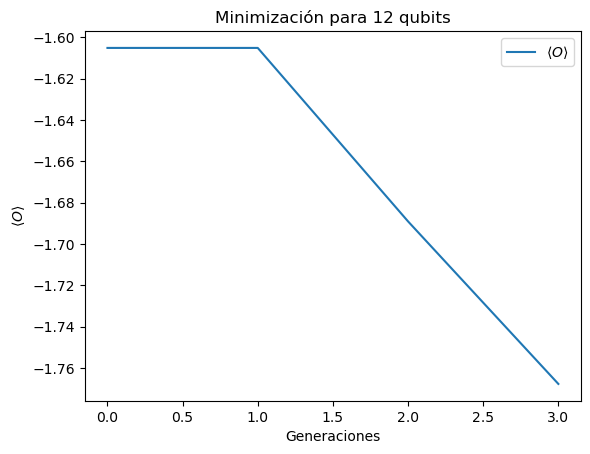

Fin ejecución con 12 qubits. Mínimo encontrado: -1.767782928430042
Número de generaciones: 4
Número de evaluaciones de la función de coste: 1702


In [34]:
data2 = VQE_minimization_AG(anz.build_twoLocal_ansatz, 4, 12, hamiltonian_H2, -1.75, population_size=500, max_iters=1000)

## H2O Molecule

In [37]:
# Hamiltonians
with open(f"H2o/data/hamiltonian1.000.pkl", "rb") as f:
    hamiltonian_H2O = pickle.load(f)

### N-local


Preparando ejecución para 14 qubits.
Se usarán 63 parámetros


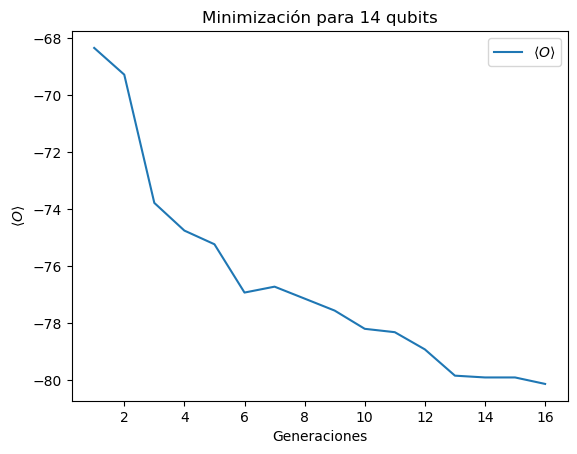

Fin ejecución con 14 qubits. Mínimo encontrado: -80.1390479077481
Número de generaciones: 16
Número de evaluaciones de la función de coste: 1076

Preparando ejecución para 15 qubits.
Se usarán 66 parámetros


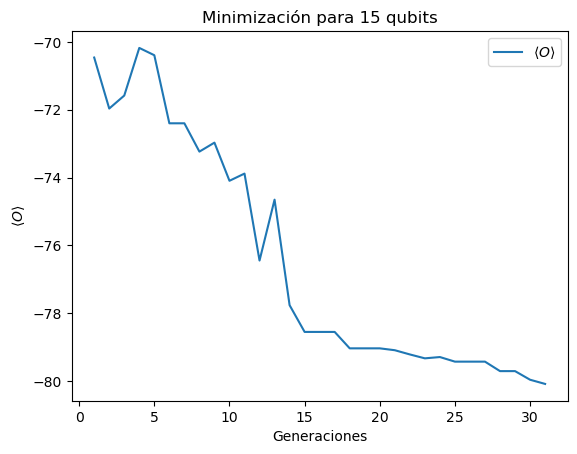

Fin ejecución con 15 qubits. Mínimo encontrado: -80.08257050709199
Número de generaciones: 31
Número de evaluaciones de la función de coste: 1976

Preparando ejecución para 16 qubits.
Se usarán 72 parámetros


KeyboardInterrupt: 

In [41]:
data = VQE_minimization_AG(anz.build_Nlocal_ansatz, 14, 18, hamiltonian_H2O, -80, population_size=100, max_iters=1000)

### 2-local


Preparando ejecución para 14 qubits.
Se usarán 28 parámetros


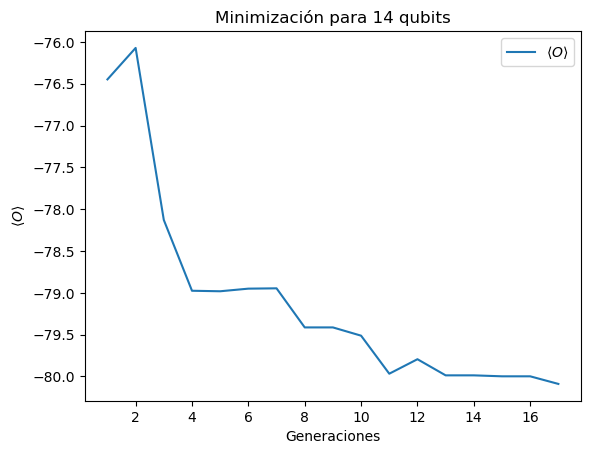

Fin ejecución con 14 qubits. Mínimo encontrado: -80.0894404108026
Número de generaciones: 17
Número de evaluaciones de la función de coste: 575


In [45]:
data = VQE_minimization_AG(anz.build_twoLocal_ansatz, 14, 14, hamiltonian_H2O, -80, population_size=50, max_iters=1000)

In [17]:
from scipy.optimize import differential_evolution


# ====================================================================
#            VQE implementation for BP study
# ====================================================================
def VQE_minimization_DE(ansatz_function, minQubits: int, maxQubits: int, base_observable, initial_guess: str = "zero", print_info: bool = True, plot_info: bool = True):
    """
    Compute the VQE algorithm using different numbers of qubits, then plot the minimization progess and the derivatives information.
    -----------------------------------------
    Args:
        ansatz_function (method): A function defined as follows: ansatz_function(N_qubits (int)) -> qc (QuantumCircuit), num_params (int)
        minQubits (int): The smallest number of qubits used.
        maxQubits (int): The greatest number of qubits used.
        base_observable (SparsePauliOp): The observable to be measured in its minimal form, it should use minQubits number of qubits.
        index (list[int] or str): With respect to which parameters the derivative will be taken. If given "all", it calculates all the derivatives.
        initial_guess (str or NumPy 1D array): "zero" initial guess with all parameters equal to cero, "rand" -> random initial guess. 1D Array -> the initial guess. default="zero".
        minimizer (str): scipy.optimize.minimize possible optimization methods, default="COBYLA".
    -----------------------------------------
    Returns:
        (Dictionary): 
            "minimum_values" : (list[float]): A list containing the minimum found for every number of qubits.
            "n_qubits" : (list[int]): A list containing the number of qubits used.
    """

    data = {
        "n_qubits": [],
        "minimum_values": []
    }

    for i in range(minQubits, maxQubits+1):

        estimator = Estimator()
        
        current_observable = cf.expand_observable(base_observable, i)
        ansatz_circuit, num_params = ansatz_function(i)

        # Initial parameters
        if initial_guess == "rand":
            initial_param_vector = np.random.random(num_params)
        elif initial_guess == "zero":
            initial_param_vector = np.zeros(num_params)
        elif initial_guess is np.ndarray():
            initial_param_vector = initial_guess
        else:
            print("Invalid initial guess, using all parameters as zero")

        # Current iteration information
        if print_info:
            print("\n=====================================================")
            print(f"Preparando ejecución para {i} qubits.")
            print(f"Se usarán {num_params} parámetros")

        # Dictionary to save the evolution of the cost function
        cost_history_dict = {
            "iters": 0,
            "cost_history": []
        }
        
        def cost_func(params, ansatz, observable, estimator):

            cost = cf.evaluate_observable(params, ansatz, observable, estimator)
            cost_history_dict["iters"] += 1
            cost_history_dict["cost_history"].append(cost)

            return cost

        # Optimization
        res = differential_evolution(
            cost_func,
            bounds=[(0, 2*np.pi) for n in range(num_params)],
            args=(ansatz_circuit, current_observable, estimator)
        )

        # Save the results in the dictionary
        data["n_qubits"].append(i)
        data["minimum_values"].append(res.fun)

        # Show the evolution of the cost function
        if plot_info:
            fig, ax = plt.subplots()
            ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"], label=r"$\langle O\rangle$")

            ax.set_xlabel("Iteraciones")
            ax.set_ylabel(r"$\langle O\rangle$")
            ax.set_title(f"Minimización para {i} qubits")
            plt.legend()
            plt.show()

        if plot_info:
            print(f"Fin ejecución con {i} qubits. Mínimo encontrado: {res.fun}")
            print("=====================================================")

    return data


Preparando ejecución para 4 qubits.
Se usarán 18 parámetros


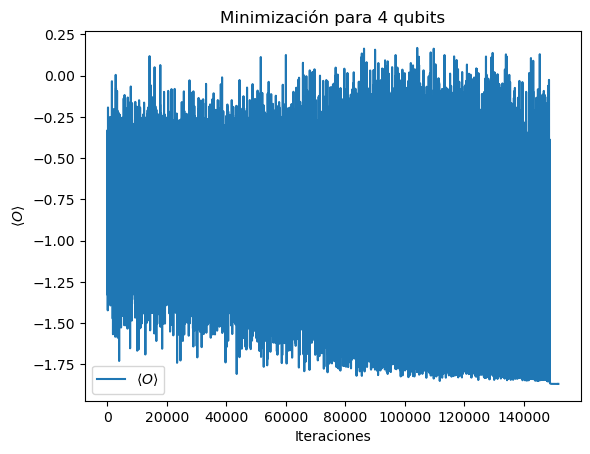

Fin ejecución con 4 qubits. Mínimo encontrado: -1.8680386376751572

Preparando ejecución para 5 qubits.
Se usarán 21 parámetros


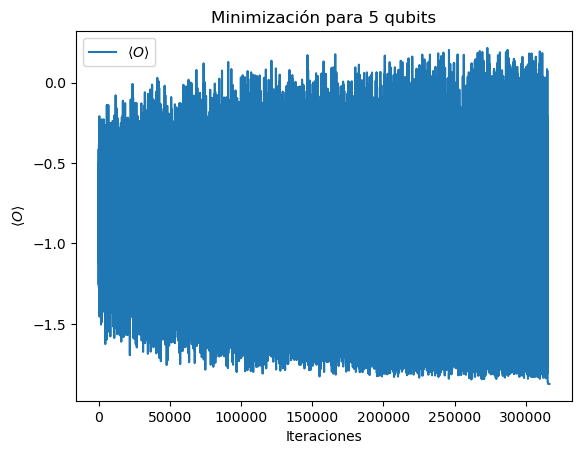

Fin ejecución con 5 qubits. Mínimo encontrado: -1.8733235813363935

Preparando ejecución para 6 qubits.
Se usarán 27 parámetros


KeyboardInterrupt: 

In [18]:
# Hamiltonians
with open(f"H2/data/hamiltonian0.719.pkl", "rb") as f:
    hamiltonian = pickle.load(f)


data = VQE_minimization_DE(anz.build_Nlocal_ansatz, 4, 12, hamiltonian)